## Prompts

This information is available to the system prompt of our agent:
- system prompt: description of tools, warnings, syntax
- graph schema: node and edge collections
- examples: successful question and code pairs from previous runs

In [1]:
with open('prompts/agent_system_prompt.txt', 'r') as f:
    SYSTEM_PROMPT = f.read().replace("{", "{{").replace("}", "}}")

with open("prompts/graph_schema.txt", "r") as f:
    GRAPH_SCHEMA = f.read().replace("{", "{{").replace("}", "}}")

In [2]:
import json

with open("prompts/networkx_examples.json", "r") as f:
    NETWORKX_EXAMPLES = json.load(f)

for example in NETWORKX_EXAMPLES:
    example["code"] = example["code"].replace("{", "{{").replace("}", "}}")

In [3]:
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_core.prompts import FewShotPromptTemplate, PromptTemplate
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

import os
from dotenv import load_dotenv

load_dotenv()

True

**Example Selector and Dynamic Prompting**

In [4]:
example_prompt = PromptTemplate(
    input_variables=["question", "code"],
    template="QUESTION: {question} \n CODE: {code} \n\n",
)
example_selector = SemanticSimilarityExampleSelector.from_examples(
    NETWORKX_EXAMPLES,
    OpenAIEmbeddings(model="text-embedding-3-small", api_key=os.getenv("OPENAI_API_KEY")),
    Chroma,
    k=1,
)

In [5]:
AGENT_PROMPT = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix=SYSTEM_PROMPT + "\n\n" + GRAPH_SCHEMA + "\n\n This could be a relevant example if the question involves NetworkX Algorithms (NOTE You do not have to strictly follow the example, you can use it as a reference if it relates to the question): ",
    suffix="",
    input_variables=["question"],
)

In [6]:
print(AGENT_PROMPT.format(question="identify community of providers in the graph"))

## Agent Overview
You are an agent specializing in analyzing graphs stored in ArangoDB. Depending on the task, you choose between:
- **AQL (`graph_traversal`)** for structured queries and fast retrieval.  
- **NetworkX (`networkx_analysis`)** for advanced graph algorithms.  
- **Vector Search (`vector_search`)** for semantic similarity and unstructured data. 
- **Pyvis (`graph_visualization`)** for displaying a subgraph view. 

---

## TOOLS

### 1. **Graph Traversal (AQL)**
- **Purpose**: Execute AQL queries for structured graph traversal in ArangoDB.
- **Use Cases**: 
  - Retrieving specific nodes/edges.
  - Shallow traversals (1-2 hops).
  - Attribute-based queries and filtering.
- **Execution**:
   - LIMIT your AQL queries to 5 examples unless explicitly mentioned. 
   ALWAYS place the LIMIT statement anywhere before RETURN. 
   - ALWAYS include a WITH clause at the beginning listing all collections that are part of the traversal, including intermediate and endpoint collections. 
 

## Toolkit

**Initialize Graph and Vector DB Clients**

In [7]:
from dotenv import load_dotenv
from arango import ArangoClient
import os

load_dotenv()

DATABASE = ArangoClient(hosts=os.getenv("ARANGO_HOST")).db(
    username=os.getenv("ARANGO_USERNAME"),
    password=os.getenv("ARANGO_PASSWORD"),
    verify=True,
)

In [8]:
import nx_arangodb as nxadb
import networkx as nx

GRAPH = nxadb.Graph(db=DATABASE, name="SYNTHEA_P100")

[15:07:14 +0700] [INFO]: NetworkX-cuGraph is unavailable: No module named 'cupy'.
[15:07:15 +0700] [INFO]: Graph 'SYNTHEA_P100' exists.
[15:07:16 +0700] [INFO]: Default node type set to 'allergies'


In [9]:
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_client = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
index = vector_client.Index("synthea-desc")
VECTOR_STORE = PineconeVectorStore(index=index, embedding=embeddings)

c:\Users\louis\Documents\hackathons\arangohack_2.0\.venv\Lib\site-packages\pinecone\data\index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [10]:
from langchain.tools import BaseTool
from pydantic import BaseModel, Field
from typing import Type
import json
import sys
from io import StringIO
from pyvis.network import Network

### Vector Search: for semantic lookup

In [11]:
class VectorSearchSchema(BaseModel):
    query: str = Field(
        ..., description="The search query to find semantically similar information"
    )
    collection: str = Field(..., description="The collection to search in")


class VectorSearchTool(BaseTool):
    name: str = "vector_search"
    description: str = (
        "Search for semantically similar information in a vector database"
    )
    args_schema: Type[BaseModel] = VectorSearchSchema

    def _run(self, query: str, collection: str) -> str:
        """Run vector search on a specific collection with the given query"""
        try:
            results = VECTOR_STORE.similarity_search(
                query, k=3, filter={"collection": collection}
            )

            formatted_results = []
            for doc in results:
                formatted_results.append(
                    {"content": doc.page_content, "metadata": doc.metadata}
                )

            return json.dumps(formatted_results, indent=2)

        except Exception as e:
            return f"Vector search failed: {str(e)}"

### AQL: for data retrieval or graph traversal

In [12]:
class GraphTraversalSchema(BaseModel):
    code: str = Field(..., description="The AQL query to execute on the graph database")


class GraphTraversalTool(BaseTool):
    name: str = "graph_traversal"
    description: str = (
        "Execute AQL queries to traverse the graph and extract structured relationships"
    )
    args_schema: Type[BaseModel] = GraphTraversalSchema

    def _run(self, code: str) -> str:
        """Execute an AQL query on ArangoDB"""
        try:
            results = GRAPH.query(code)
            return json.dumps(list(results), indent=2)
        except Exception as e:
            return f"AQL Code Execution failed: {str(e)}"

### Network X: graph algorithms

In [13]:
class NetworkxAnalysisSchema(BaseModel):
    code: str = Field(
        ...,
        description="The Python code to execute NetworkX algorithms on the graph variable",
    )


class NetworkxAnalysisTool(BaseTool):
    name: str = "networkx_analysis"
    description: str = "Execute Python code to run NetworkX algorithms on the graph"
    args_schema: Type[BaseModel] = NetworkxAnalysisSchema

    def _run(self, code: str) -> str:
        """Execute Python code with NetworkX algorithms in a controlled environment"""
        try:
            env = {"G": GRAPH, "nx": nx}

            # Redirect stdout to capture print statements
            old_stdout = sys.stdout
            sys.stdout = StringIO()

            # Execute the provided Python code
            exec(code, env)

            # Capture output
            output = sys.stdout.getvalue()
            sys.stdout = old_stdout

            # Check if 'result' is defined in the environment (expected output variable)
            if "result" in env:
                return env["result"]
            elif output:
                return output.strip()
            else:
                return "No result variable or output produced"
        except Exception as e:
            return f"NetworkX analysis failed: {str(e)}"

### PyVis: sub-graph visualizations

In [14]:
COLOR_MAP = {
    "allergies": "#FF5733",  # Red-orange
    "careplans": "#33FF57",  # Green
    "conditions": "#3357FF",  # Blue
    "devices": "#FF33F5",    # Pink
    "encounters": "#33FFF5", # Cyan
    "imaging_studies": "#F5FF33", # Yellow
    "immunizations": "#FF8C33", # Orange
    "medications": "#8C33FF", # Purple
    "observations": "#33FF8C", # Light green
    "organizations": "#FF3333", # Red
    "patients": "#3333FF",    # Deep blue
    "payers": "#FFCC33",      # Gold
    "procedures": "#33FFCC",  # Turquoise
    "providers": "#CC33FF",   # Violet
    "supplies": "#CCFF33"     # Lime
}

class GraphVisualizationSchema(BaseModel):
    nodes: list = Field(
        ...,
        description="List of dictionaries with keys 'id' and 'label' representing nodes to visualize",
    )
    edges: list = Field(
        ...,
        description="List of dictionaries with keys 'from' and 'to' representing node IDs to connect",
    )
    title: str = Field(default="Graph Visualization", description="Title of the graph")


class GraphVisualizationTool(BaseTool):
    name: str = "graph_visualization"
    description: str = (
        "Generate an interactive graph visualization using pyvis from nodes and edges data"
    )
    args_schema: Type[BaseModel] = GraphVisualizationSchema

    def _run(
        self,
        nodes: list,
        edges: list,
        title: str,
    ) -> str:
        """Generate a pyvis graph from nodes and edges and return the HTML file path or content"""
        try:
            net = Network(
                notebook=True,
                directed=True,
                height="500px",
                width="100%",
                heading=title,
            )

            for node in nodes:
                collection = node["id"].split("/")[0]
                color = COLOR_MAP.get(collection, "#CCCCCC")
                
                net.add_node(
                    node["id"],
                    label=node.get("label", node["id"]),
                    title=collection,
                    color=color
                )

            for edge in edges:
                net.add_edge(edge["from"], edge["to"])

            net.save_graph("visualization.html")
            return "Graph visualization generated. Open it in a browser to view."

        except Exception as e:
            return f"Graph visualization failed: {str(e)}"

### AGENT

**REACT Agent Design**   
In the future, we'll look into other agentic designs that allow the separation of concerns, and more deterministic output

In [15]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages

In [16]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
graph_builder = StateGraph(State)

In [17]:
llm = ChatOpenAI(model="gpt-4o", temperature=0)
TOOLKIT = [GraphVisualizationTool(), NetworkxAnalysisTool(), GraphTraversalTool(), VectorSearchTool()]
llm_with_tools = llm.bind_tools(TOOLKIT)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [18]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

tool_node = ToolNode(tools=TOOLKIT)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")

workflow = graph_builder.compile(checkpointer=MemorySaver())

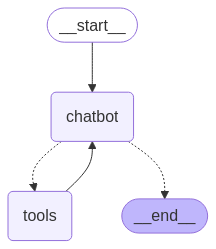

In [19]:
from IPython.display import Image, display

display(Image(workflow.get_graph().draw_mermaid_png()))

### Query Engine

**Each thread ID allows for a dedicated conversation, and allows you to resume from where you're left off**

In [20]:
def ask_query(question: str, config: dict, start: bool):
    messages = []
    if start:
        messages.append({"role": "system", "content": AGENT_PROMPT.format(question=question)})
    messages.append(
        {
            "role": "user",
            "content": f"Using the knowledge provided, answer the question: {question}",
        }
    )
    events = workflow.stream(
        {"messages": messages},
        stream_mode="values",
        config=config,
    )
    for event in events:
        event["messages"][-1].pretty_print()
    return workflow.get_state(config=config)

Here are some query examples that utilizes a wide range of tools (multimodal + hybrid). 

**DISCLAIMER**: This agent has the possibility to make mistakes, such as choosing the wrong set of tools, but it will try its best to correct itself.

**LIMITATIONS**: Because the nature of our knowledge graph is very large (145514 nodes, 311701 edges) some algorithms are not scalable to run on the entire graph. Instead the agent has been promtped to create a subgraph and randomly sample nodes to analyze. 

In [21]:
config = {"configurable": {"thread_id": "0"}}
user_input = "What injections has Shila857 (first name) ever taken? "
response = ask_query(user_input, config, True)

================================ Human Message =================================

Using the knowledge provided, answer the question: What injections has Shila857 (first name) ever taken? 
================================== Ai Message ==================================
Tool Calls:
  graph_traversal (call_khmkWBKN5B6pSIETR71Zjxxs)
 Call ID: call_khmkWBKN5B6pSIETR71Zjxxs
  Args:
    code: WITH patients, immunizations, patients_to_immunizations
FOR pat IN patients
  FILTER pat.FIRST == "Shila857"
  FOR imm IN 1..1 OUTBOUND pat patients_to_immunizations
    RETURN {immunization_id: imm._key, description: imm.DESCRIPTION}
================================= Tool Message =================================
Name: graph_traversal

[
  {
    "immunization_id": "57",
    "description": "Influenza  seasonal  injectable  preservative free"
  },
  {
    "immunization_id": "55",
    "description": "DTaP"
  },
  {
    "immunization_id": "49",
    "description": "Hep A  ped/adol  2 dose"
  },
  {
    "immu

In [22]:
config = {"configurable": {"thread_id": "1"}}
user_input = "Which providers play the most critical role in the healthcare network based on their connections to multiple encounters? use degree centrality. "
response = ask_query(user_input, config, True)

================================ Human Message =================================

Using the knowledge provided, answer the question: Which providers play the most critical role in the healthcare network based on their connections to multiple encounters? use degree centrality. 
================================== Ai Message ==================================
Tool Calls:
  networkx_analysis (call_C3dm5uLHA2rclUEQnztzUiBj)
 Call ID: call_C3dm5uLHA2rclUEQnztzUiBj
  Args:
    code: import random

# Create a subgraph for providers and encounters
H = nx.DiGraph()
provider_nodes = [n for n in G.nodes if n.startswith("providers/")]

# Randomly sample 10 provider nodes to limit the computation
sampled_providers = random.sample(provider_nodes, min(10, len(provider_nodes)))

for prov in sampled_providers:
    H.add_node(prov)
    # Find encounters connected to the provider
    for encounter in G.neighbors(prov):
        if encounter.startswith("encounters/"):
            H.add_node(encounter)
     

In [23]:
config = {"configurable": {"thread_id": "2"}}
user_input = "Find procedures related to pregnancy. "
response = ask_query(user_input, config, True)

================================ Human Message =================================

Using the knowledge provided, answer the question: Find procedures related to pregnancy. 
================================== Ai Message ==================================
Tool Calls:
  vector_search (call_LXU4T8F8OIbYJgwrHFWvHeKi)
 Call ID: call_LXU4T8F8OIbYJgwrHFWvHeKi
  Args:
    query: pregnancy
    collection: procedures
================================= Tool Message =================================
Name: vector_search

[
  {
    "content": "Standard pregnancy test",
    "metadata": {
      "_key": "99",
      "collection": "procedures"
    }
  },
  {
    "content": "Childbirth",
    "metadata": {
      "_key": "433",
      "collection": "procedures"
    }
  },
  {
    "content": "Pregnancy termination care",
    "metadata": {
      "_key": "443",
      "collection": "procedures"
    }
  }
]
================================== Ai Message ==================================

Here are some procedures rel

In [29]:
config = {"configurable": {"thread_id": "3"}}
user_input = "Which patients were immunized with covid related virus?"
response = ask_query(user_input, config, True)

================================ Human Message =================================

Using the knowledge provided, answer the question: Which patients were immunized with covid related virus?
================================== Ai Message ==================================
Tool Calls:
  vector_search (call_DfHbSZIdOT0zM8YhGKccZQe0)
 Call ID: call_DfHbSZIdOT0zM8YhGKccZQe0
  Args:
    query: covid
    collection: immunizations
================================= Tool Message =================================
Name: vector_search

[
  {
    "content": "SARS-COV-2 (COVID-19) vaccine  mRNA  spike protein  LNP  preservative free  30 mcg/0.3mL dose",
    "metadata": {
      "_key": "139",
      "collection": "immunizations"
    }
  },
  {
    "content": "SARS-COV-2 (COVID-19) vaccine  mRNA  spike protein  LNP  preservative free  100 mcg/0.5mL dose",
    "metadata": {
      "_key": "117",
      "collection": "immunizations"
    }
  },
  {
    "content": "SARS-COV-2 (COVID-19) vaccine  vector non-repl

In [25]:
config = {"configurable": {"thread_id": "4"}}
user_input = "Visualize the network of payers to their medications. "
response = ask_query(user_input, config, True)

================================ Human Message =================================

Using the knowledge provided, answer the question: Visualize the network of payers to their medications. 
================================== Ai Message ==================================
Tool Calls:
  graph_traversal (call_OkBV3mCMJnYvg1cjYu7Qrx37)
 Call ID: call_OkBV3mCMJnYvg1cjYu7Qrx37
  Args:
    code: WITH payers, medications, payers_to_medications
FOR payer IN payers
  LET meds = (
    FOR med IN 1..1 OUTBOUND payer payers_to_medications
      LIMIT 3
      RETURN { id: med._id, label: med.DESCRIPTION }
  )
  LIMIT 3
  RETURN { payer_id: payer._id, payer_name: payer.NAME, medications: meds }
================================= Tool Message =================================
Name: graph_traversal

[
  {
    "payer_id": "payers/a735bf55-83e9-331a-899d-a82a60b9f60c",
    "payer_name": "Medicare",
    "medications": [
      {
        "id": "medications/8341",
        "label": "Alteplase 100 MG Injection"
  

Visualization saved as `visualization.html`. open in a web browser to interact. 

In [26]:
config = {"configurable": {"thread_id": "5"}}
user_input = "What is the shortest path of encounters a patient had before receiving diabetes? "
response = ask_query(user_input, config, True)

================================ Human Message =================================

Using the knowledge provided, answer the question: What is the shortest path of encounters a patient had before receiving diabetes? 
================================== Ai Message ==================================

To find the shortest path of encounters a patient had before receiving a diabetes diagnosis, we need to follow these steps:

1. **Identify the Patient**: We need the patient's ID to start the path.
2. **Identify the Diabetes Condition**: We need to find the condition ID for diabetes.
3. **Use NetworkX to Find the Shortest Path**: We will use NetworkX to find the shortest path from the patient to the diabetes condition through their encounters.

Let's start by identifying the condition ID for diabetes using a vector search. Then, we will use NetworkX to find the shortest path.
Tool Calls:
  vector_search (call_BhYXEBBCMNuOYbEBH12kPvmD)
 Call ID: call_BhYXEBBCMNuOYbEBH12kPvmD
  Args:
    query: d

In [21]:
config = {"configurable": {"thread_id": "6"}}
user_input = "Are there outlier patients who receive an unusually high number of procedures or medications compared to others?"
response = ask_query(user_input, config, True)

================================ Human Message =================================

Using the knowledge provided, answer the question: Are there outlier patients who receive an unusually high number of procedures or medications compared to others?
================================== Ai Message ==================================
Tool Calls:
  networkx_analysis (call_emulx2V7qJjFqjmBpI3NizxD)
 Call ID: call_emulx2V7qJjFqjmBpI3NizxD
  Args:
    code: import numpy as np

# Initialize dictionaries to count procedures and medications for each patient
patient_procedure_count = {}
patient_medication_count = {}

# Iterate over all edges in the graph
for u, v in G.edges:
    # Check for procedures
    if u.startswith('patients/') and v.startswith('procedures/'):
        patient_procedure_count[u] = patient_procedure_count.get(u, 0) + 1
    # Check for medications
    elif u.startswith('patients/') and v.startswith('medications/'):
        patient_medication_count[u] = patient_medication_count.get(u